In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats

In [3]:
df = pd.read_csv(
    "http://www.stat.columbia.edu/~gelman/arm/examples/police/frisk_with_noise.dat",
    skiprows=6,
    delimiter=" ",
)

In [4]:
# print(df.head().to_html())

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
stops           900 non-null int64
pop             900 non-null int64
past.arrests    900 non-null int64
precinct        900 non-null int64
eth             900 non-null int64
crime           900 non-null int64
dtypes: int64(6)
memory usage: 42.3 KB


In [6]:
X = (df
    .groupby(['eth', 'precinct'])[["stops", "past.arrests"]]
    .sum()
    .reset_index()
    .pipe(pd.get_dummies, columns=['eth', 'precinct'])
    .assign(intercept=1)
    .sort_values(by='stops')
    .reset_index(drop=True)
)

y = X.pop("stops")

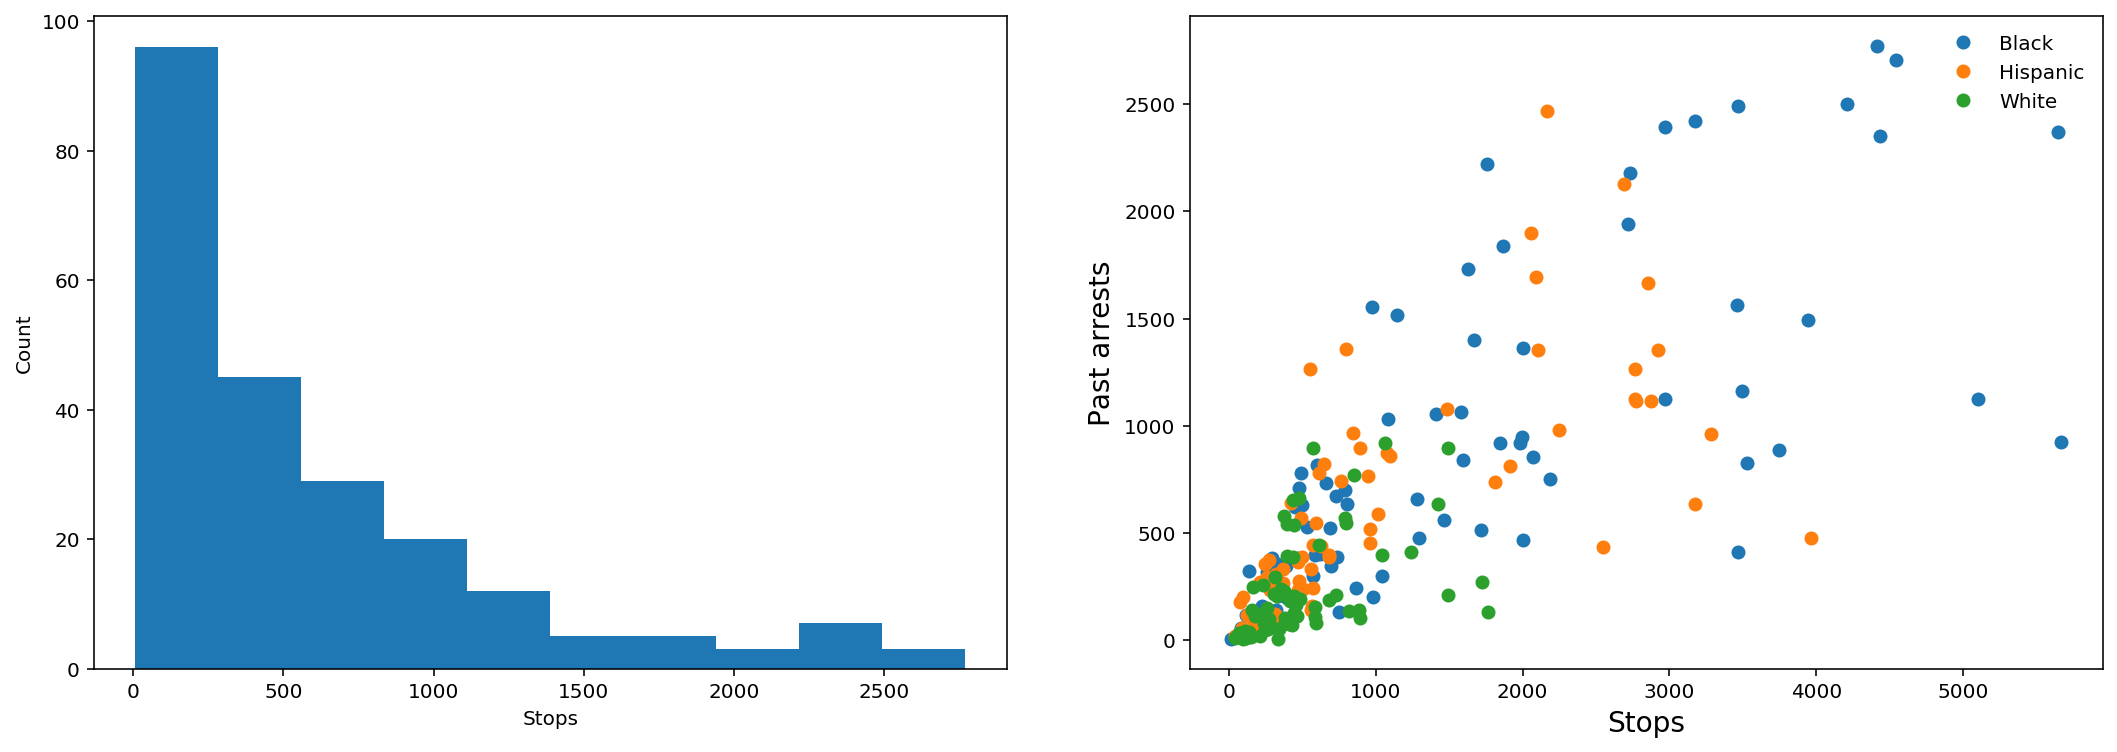

In [7]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].hist(y)
axes[0].set_xlabel("Stops")
axes[0].set_ylabel("Count")
axes[1].plot(X.loc[X.eth_1 == 1, "past.arrests"], y.loc[X.eth_1 == 1], 'o', label="Black")
axes[1].plot(X.loc[X.eth_2 == 1, "past.arrests"], y.loc[X.eth_2 == 1], 'o', label="Hispanic")
axes[1].plot(X.loc[X.eth_3 == 1, "past.arrests"], y.loc[X.eth_3 == 1], 'o', label="White")
axes[1].set_xlabel("Stops", fontsize=14)
axes[1].set_ylabel("Past arrests", fontsize=14)
# plt.rc('font', size=14)
plt.legend(frameon=False)
plt.show()

## Poisson regression, exposure and overdispersion

In [8]:
model_no_indicators = sm.GLM(
    y,
    X["intercept"],
    offset=np.log(X["past.arrests"]),
    family=sm.families.Poisson(),
#     family=sm.families.NegativeBinomial(),
)

In [9]:
result_no_indicators = model_no_indicators.fit()

In [10]:
result_no_indicators.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      224
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23913.
Date:                Tue, 26 May 2020   Deviance:                       46120.
Time:                        05:58:40   Pearson chi2:                 4.96e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5877      0.003   -213.058      0.000      -0.593      -0.582
==============================================================================
"""

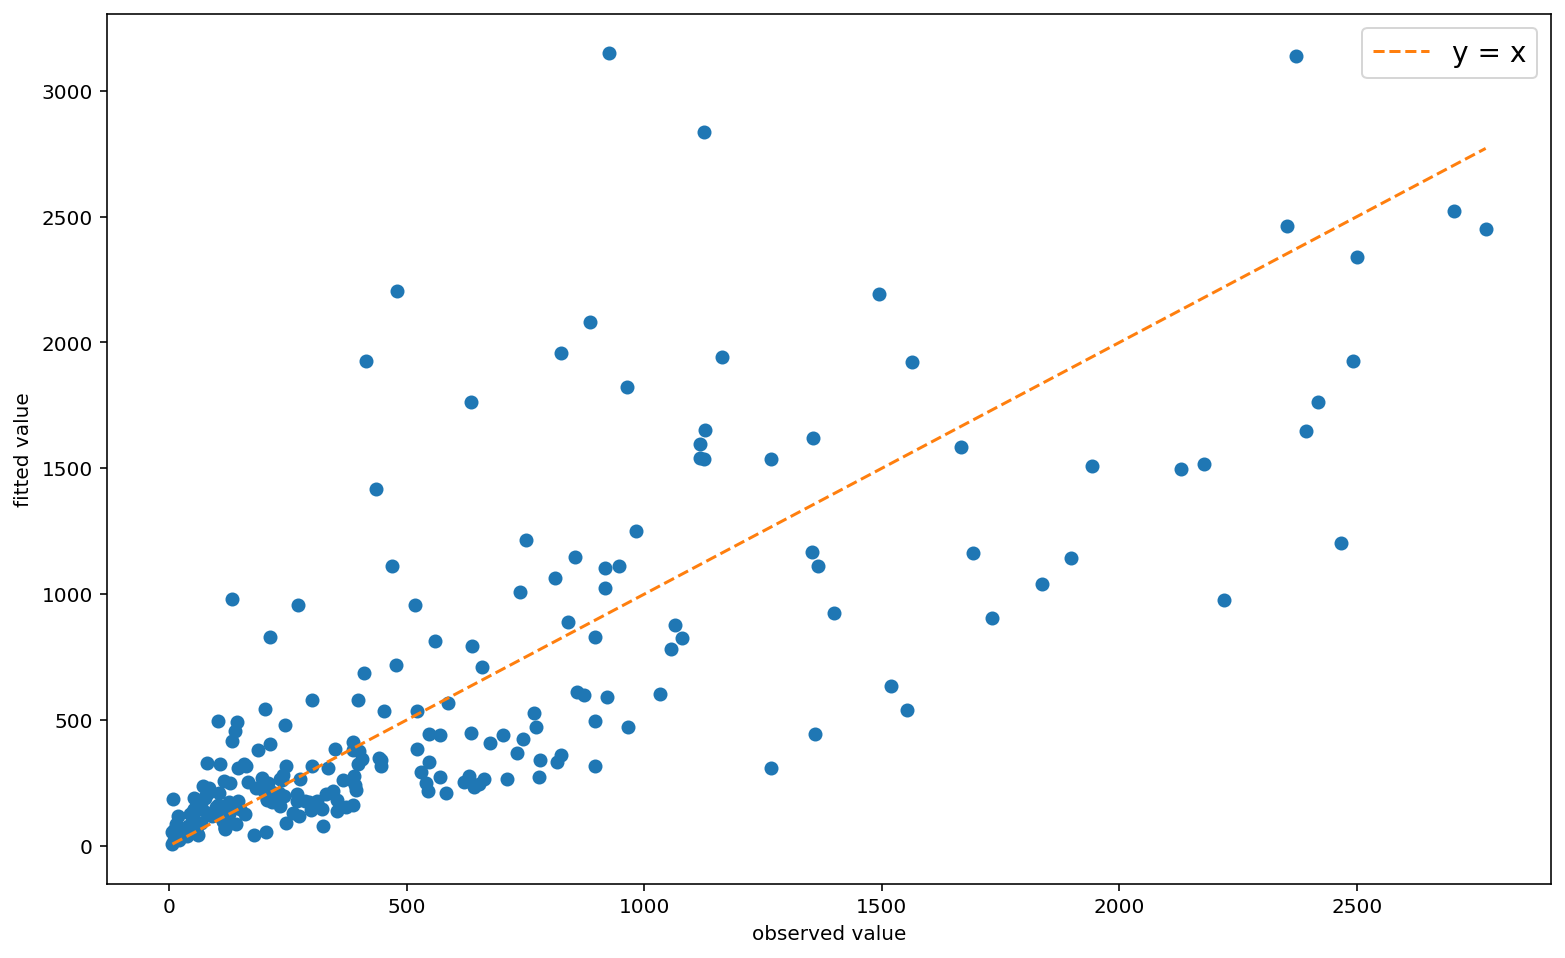

In [11]:
plt.figure(figsize=(8 * 1.618, 8))
plt.plot(y, result_no_indicators.fittedvalues, 'o')
plt.plot(y, y, '--', label='y = x')
plt.rc('font', size=14)
plt.ylabel("fitted value")
plt.xlabel("observed value")
plt.legend()
plt.show()

In [12]:
model_with_ethnicity = sm.GLM(
    y,
    X[['intercept', 'eth_2', 'eth_3']],
    offset=np.log(X["past.arrests"]),
    family=sm.families.Poisson(),
#     family=sm.families.NegativeBinomial(),
)

In [13]:
result_with_ethnicity = model_with_ethnicity.fit()
print(result_with_ethnicity.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      222
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23572.
Date:                Tue, 26 May 2020   Deviance:                       45437.
Time:                        05:58:44   Pearson chi2:                 4.94e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5881      0.004   -155.396      0.0

In [204]:
from statsmodels.discrete.discrete_model import Poisson

In [211]:
model = Poisson(
    y,
    X.drop(columns=["eth_1", "precinct_1", "past.arrests"]).values,
    offset=np.log(X["past.arrests"]).values,
)

In [212]:
result = model.fit()

Optimization terminated successfully.
         Current function value: 11.408337
         Iterations 7


(array([ 7., 15., 29., 38., 52., 37., 29., 14.,  1.,  3.]),
 array([-9.35497859, -7.31564928, -5.27631997, -3.23699066, -1.19766136,
         0.84166795,  2.88099726,  4.92032657,  6.95965587,  8.99898518,
        11.03831449]),
 <a list of 10 Patch objects>)

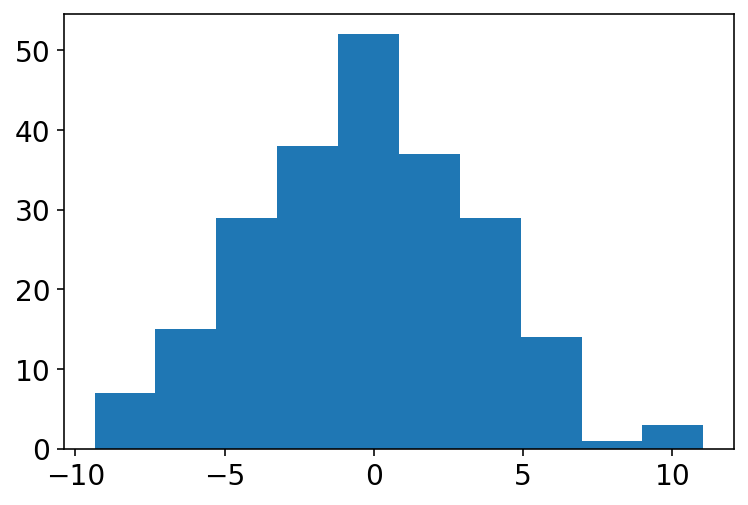

In [218]:
plt.hist(result.resid_pearson)

In [216]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                  stops   No. Observations:                  225
Model:                        Poisson   Df Residuals:                      148
Method:                           MLE   Df Model:                           76
Date:                Fri, 22 May 2020   Pseudo R-squ.:                  0.8927
Time:                        20:26:44   Log-Likelihood:                -2566.9
converged:                       True   LL-Null:                       -23913.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0102      0.007      1.498      0.134      -0.003       0.024
x2            -0.4190      0.009    -44.409      0.000      -0.437      -0.401
x3            -0.1490      0.074     -2.013      0.044      -0.294      -0.004
x4             0.5600      0.057      9.866      0.000       0.449       0.671
x5             1.2106      0.058     21.037      0.000       1.098       1.323
x6             0.2829      0.057      4.981      0.000       0.172       0.394
x7             1.1442      0.058     19.712      0.000       1.030       1.258
x8             0.2182      0.064      3.391      0.001       0.092       0.344
x9            -0.3906      0.057     -6.868      0.000      -0.502      -0.279
x10            0.4851      0.078      6.207      0.000       0.332       0.638
x11            0.4171      0.059      7.087      0.000       0.302       0.532
x12            0.6544      0.062     10.626      0.000       0.534       0.775
x13            1.1487      0.061     18.811      0.000       1.029       1.268
x14            1.0535      0.055     19.068      0.000       0.945       1.162
x15            0.6141      0.059     10.444      0.000       0.499       0.729
x16            1.0549      0.055     19.195      0.000       0.947       1.163
x17            0.7977      0.060     13.231      0.000       0.680       0.916
x18           -0.0493      0.060     -0.815      0.415      -0.168       0.069
x19            0.1316      0.055      2.394      0.017       0.024       0.239
x20            0.3192      0.058      5.503      0.000       0.205       0.433
x21           -0.0406      0.057     -0.713      0.476      -0.152       0.071
x22            0.4110      0.057      7.235      0.000       0.300       0.522
x23            1.2112      0.053     22.683      0.000       1.107       1.316
x24            0.5999      0.055     10.895      0.000       0.492       0.708
x25            1.3195      0.055     24.166      0.000       1.212       1.426
x26            0.9134      0.054     17.041      0.000       0.808       1.018
x27           -0.1476      0.057     -2.589      0.010      -0.259      -0.036
x28            1.8955      0.056     34.052      0.000       1.786       2.005
x29           -0.7650      0.061    -12.558      0.000      -0.884      -0.646
x30            1.1247      0.054     20.726      0.000       1.018       1.231
x31            0.5247      0.055      9.475      0.000       0.416       0.633
x32            1.6495      0.056     29.368      0.000       1.539       1.760
x33            1.3863      0.060     23.229      0.000       1.269       1.503
x34            1.0832      0.054     19.980      0.000       0.977       1.189
x35            1.5190      0.054     27.945      0.000       1.412       1.626
x36            0.8794      0.063     13.917      0.000       0.756       1.003
x37            1.6163      0.059     27.490      0.000       1.501       1.732
x38            1.4094      0.060     23.487      0.000       1.292       1.527
x3

In [17]:
model_with_ethnicity_and_precinct = sm.GLM(
    y,
    X.drop(columns=["eth_1", "precinct_1", "past.arrests"]),
    offset=np.log(X["past.arrests"]),
#     family=sm.families.NegativeBinomial(alpha=0.0511),
    family=sm.families.Poisson(),
)

result_with_ethnicity_and_precinct = model_with_ethnicity_and_precinct.fit()
print(result_with_ethnicity_and_precinct.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      148
Model Family:                 Poisson   Df Model:                           76
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2566.9
Date:                Tue, 26 May 2020   Deviance:                       3427.1
Time:                        05:59:39   Pearson chi2:                 3.24e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
eth_2           0.0102      0.007      1.498      

In [18]:
r = result_with_ethnicity_and_precinct.pearson_chi2 / result_with_ethnicity_and_precinct.df_resid

In [19]:
r

21.88505098420496

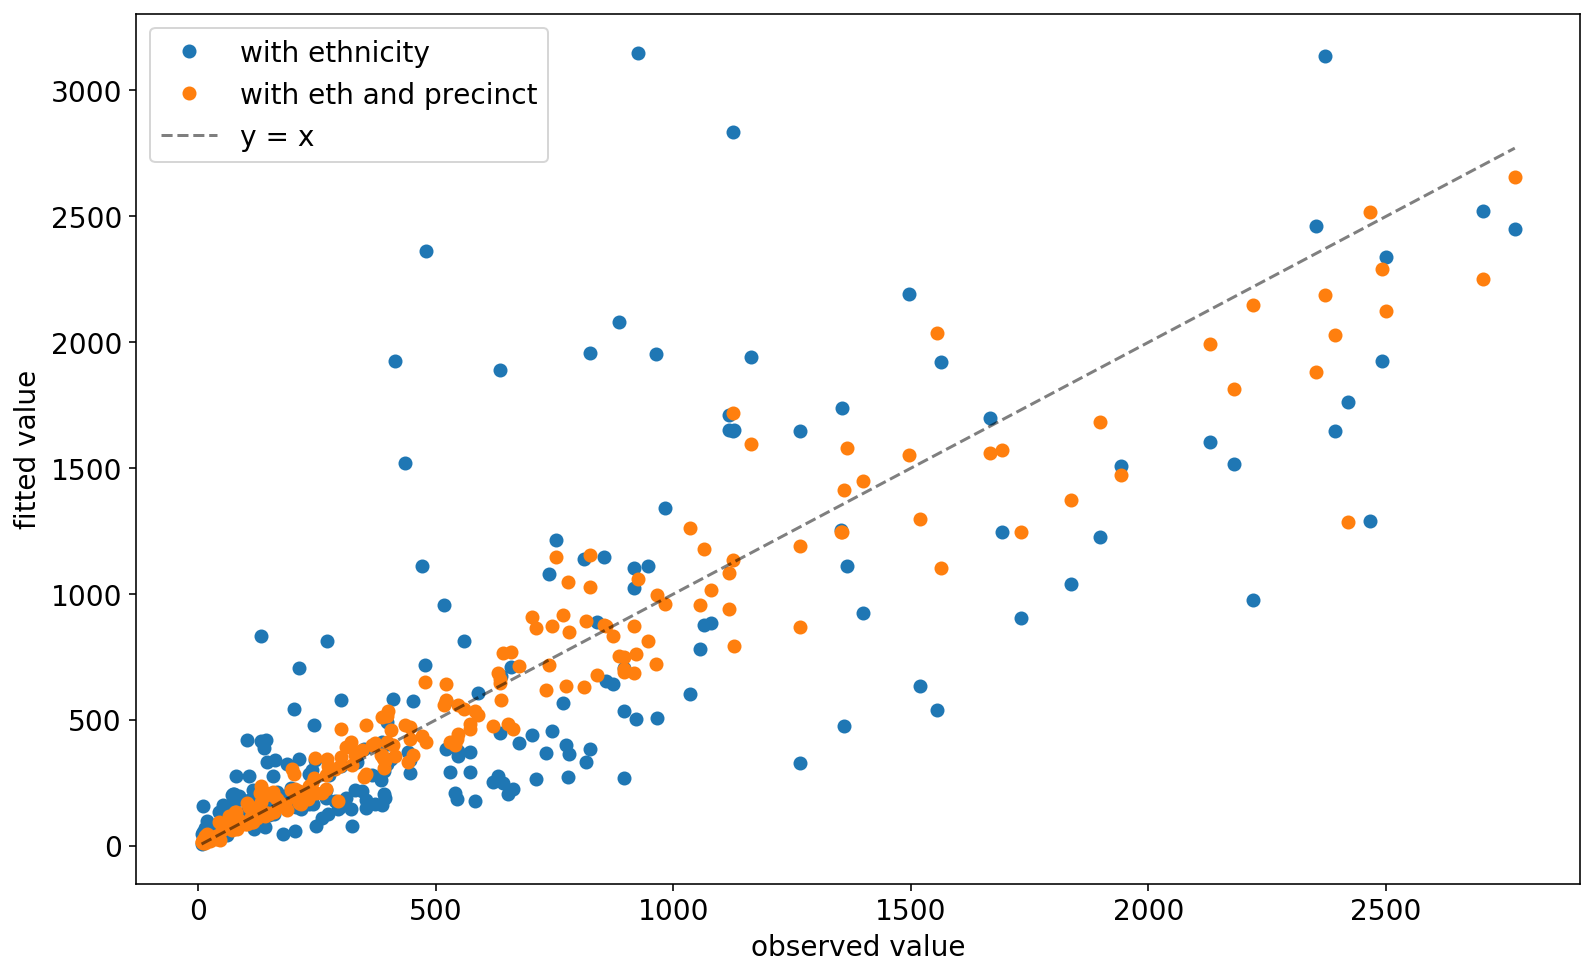

In [267]:
plt.figure(figsize=(8 * 1.618, 8))
plt.plot(y, result_with_ethnicity.fittedvalues, 'o', label='with ethnicity')
plt.plot(y, result_with_ethnicity_and_precinct.fittedvalues, 'o', label='with eth and precinct')
plt.plot(y, y, '--', label='y = x', color='black', alpha=0.5)
plt.rc('font', size=14)
plt.ylabel("fitted value")
plt.xlabel("observed value")
plt.legend()
plt.show()

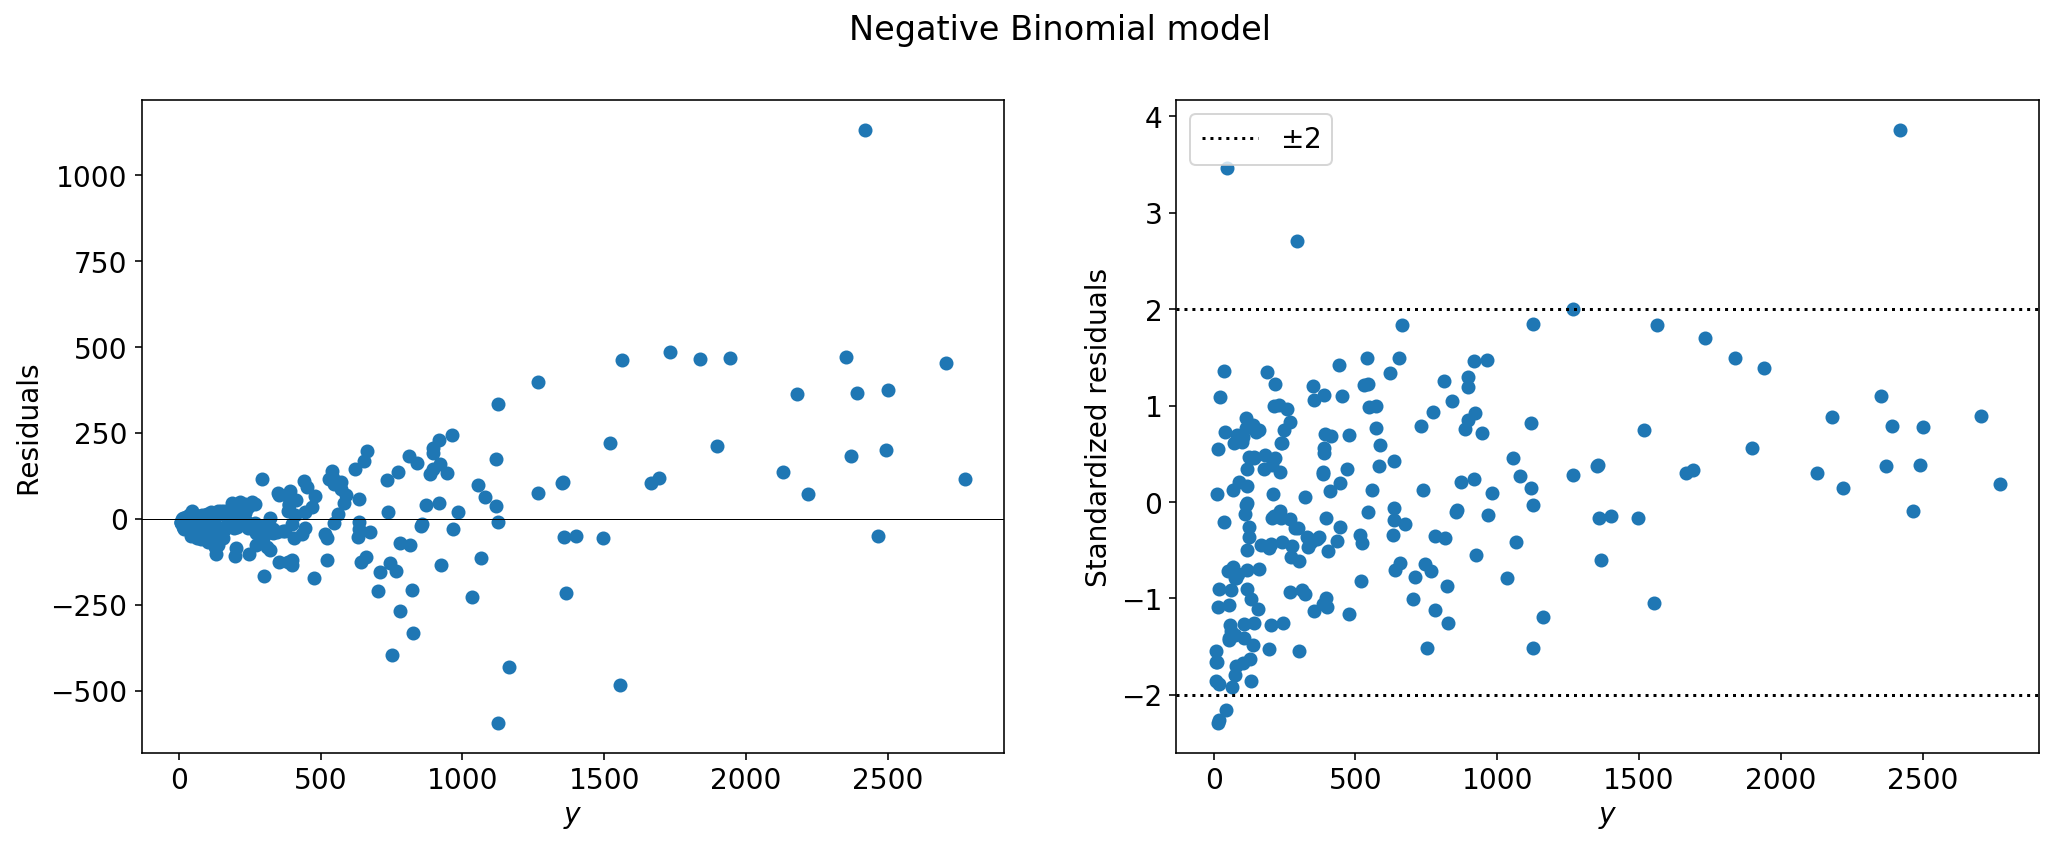

In [268]:
f, axes = plt.subplots(1, 2, figsize=(17, 6))
f.suptitle("Negative Binomial model")
axes[0].plot(y, result_with_ethnicity_and_precinct.resid_response, 'o')
axes[0].axhline(y=0, color='black', linewidth=0.5)
axes[0].set_ylabel("Residuals")
axes[0].set_xlabel("$y$")
axes[1].plot(y, result_with_ethnicity_and_precinct.resid_pearson, 'o')
axes[1].axhline(y=-2, linestyle=':', color='black', label='$\pm 2$')
axes[1].axhline(y=+2, linestyle=':', color='black')
axes[1].set_ylabel("Standardized residuals")
axes[1].set_xlabel("$y$")
plt.legend()
plt.show()

In [222]:
nb = sm.families.NegativeBinomial()

In [223]:
from statsmodels.discrete.discrete_model import NegativeBinomial

In [224]:
nb = NegativeBinomial(
    y,
#     np.ones_like(y),
    X.drop(columns=["eth_1", "precinct_1", "past.arrests"]).values,
    offset=np.log(X["past.arrests"].values),
)

In [225]:
result = nb.fit()

Optimization terminated successfully.
         Current function value: 5.785209
         Iterations: 30
         Function evaluations: 34
         Gradient evaluations: 34


In [272]:
result.params.alpha

0.051146659946954665

In [271]:
print(result.summary())

                     NegativeBinomial Regression Results                      
Dep. Variable:                  stops   No. Observations:                  225
Model:               NegativeBinomial   Df Residuals:                      148
Method:                           MLE   Df Model:                           76
Date:                Fri, 22 May 2020   Pseudo R-squ.:                  0.1525
Time:                        20:58:23   Log-Likelihood:                -1301.7
converged:                       True   LL-Null:                       -1535.9
Covariance Type:            nonrobust   LLR p-value:                 7.543e-58
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0086      0.038      0.224      0.823      -0.067       0.084
x2            -0.4858      0.040    -12.140      0.000      -0.564      -0.407
x3            -0.2385      0.202     -1.179      0.2

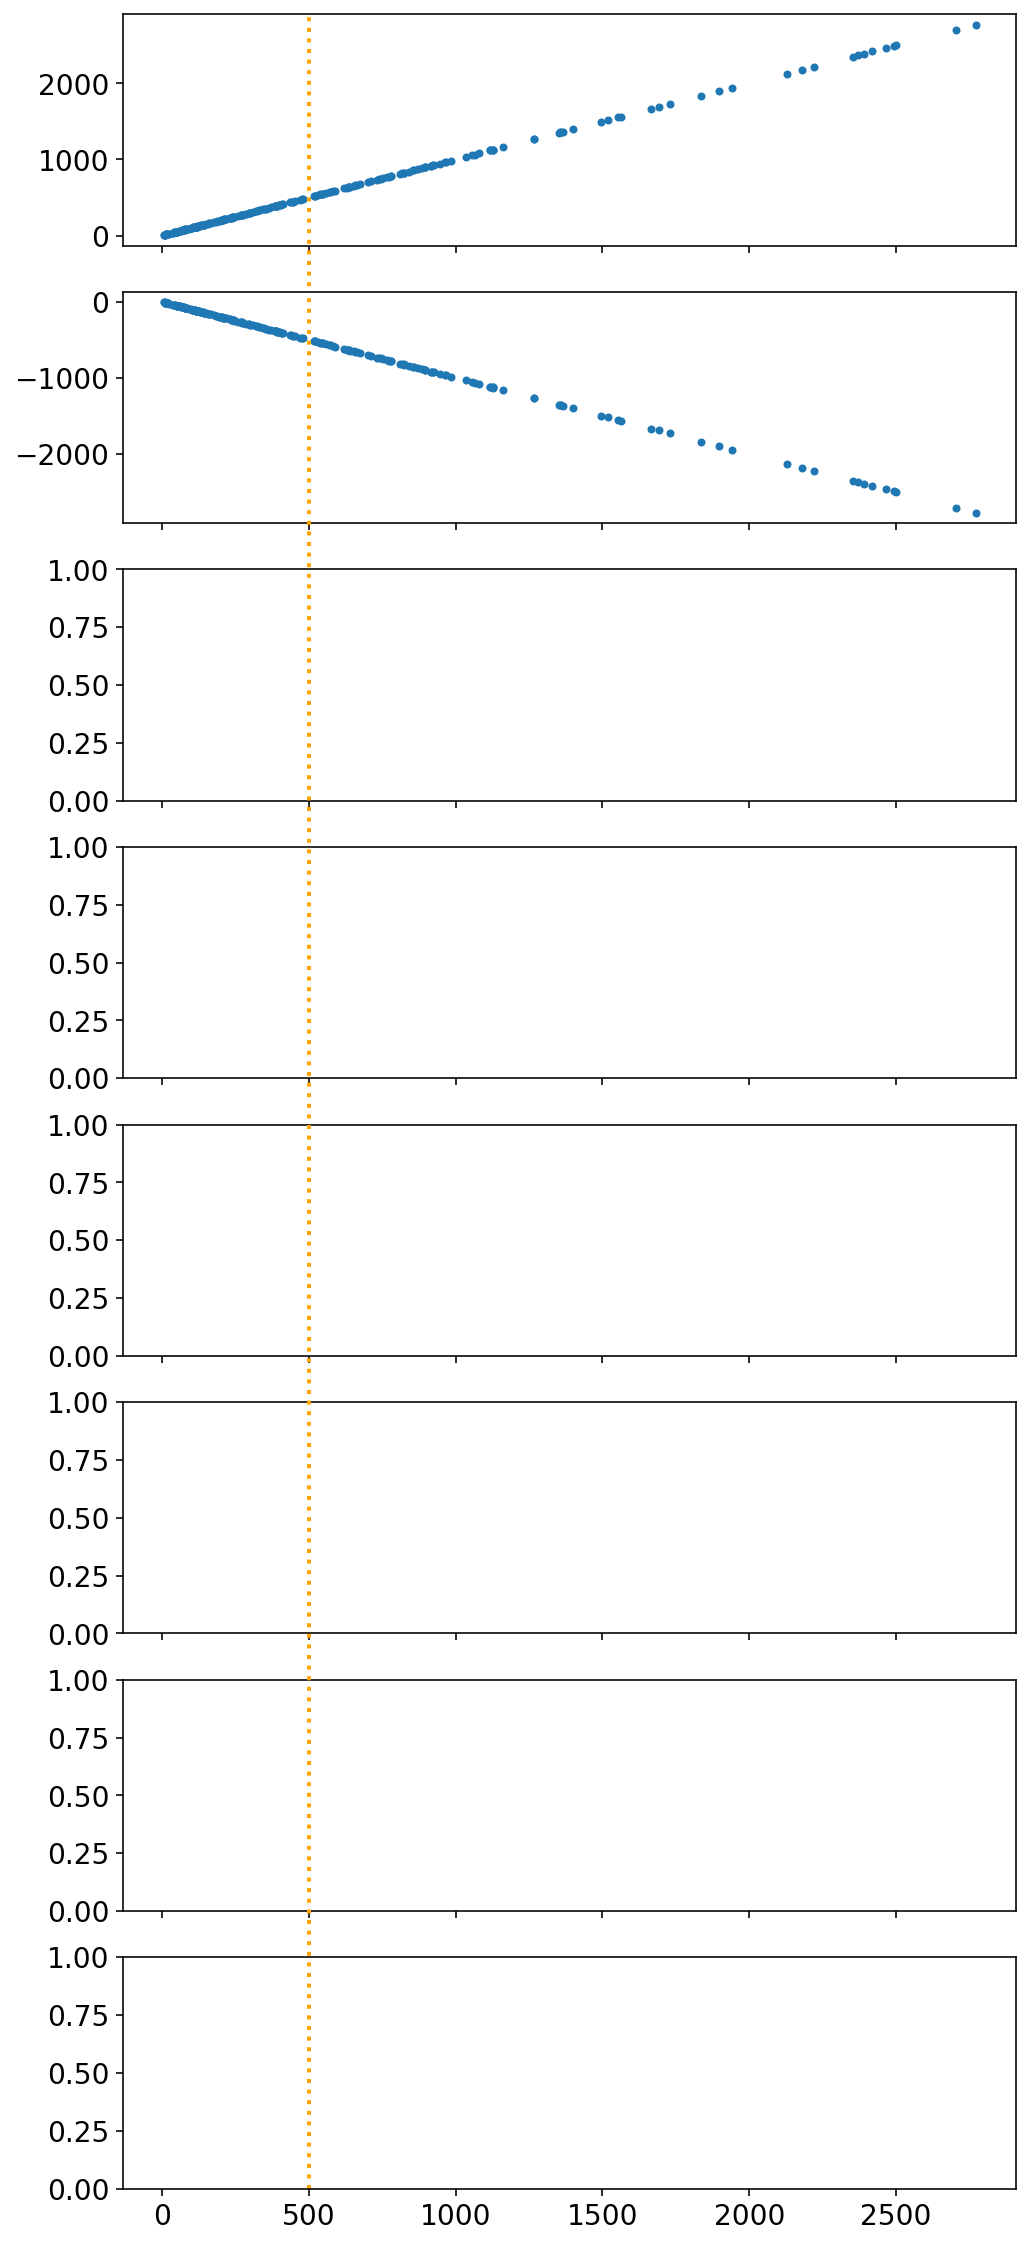

In [265]:
f, axes = plt.subplots(8, sharex=True, figsize=(8, 20))
axes[0].plot(y, y, '.')
axes[1].plot(y, -y, '.')

axes[0].axvline(x=500, ymin=-1, clip_on=False, linestyle=':', color='orange', linewidth=2)
axes[-1].axvline(x=500, ymax=8.2, clip_on=False, linestyle=':', color='orange', linewidth=2)


In [228]:
result.params

x1       0.008573
x2      -0.485847
x3      -0.238471
x4       0.580989
x5       0.959910
           ...   
x74      0.812502
x75      0.960619
x76      1.158990
const   -1.227186
alpha    0.051147
Length: 78, dtype: float64

In [233]:
result_with_ethnicity_and_precinct.params.values - result.params.values[:-1]

array([ 2.05271938e-06,  6.17439999e-06,  1.59552185e-05,  8.37610260e-06,
        3.12004593e-05,  2.70147770e-05,  2.26466069e-05,  2.08352258e-05,
        1.86068710e-05,  3.03566630e-05,  2.73462421e-05,  2.54076970e-05,
        2.01023902e-05,  3.17183365e-05,  1.82052807e-05,  1.81355182e-05,
        2.53448316e-05, -7.63327100e-05,  1.69366153e-05, -5.87424586e-06,
        3.23792275e-05,  3.32910745e-05,  4.30907829e-05,  3.31423585e-05,
        5.93891578e-05,  4.16208415e-05,  4.76527902e-05,  1.87895972e-05,
        7.26970041e-05,  3.33915017e-05,  3.10638207e-05,  2.07194191e-05,
        2.61228946e-05,  2.47728434e-05,  2.69903763e-05,  2.35232133e-05,
        2.96290558e-05,  3.42491923e-05,  2.10642663e-05,  2.47524354e-05,
        3.23010986e-05,  2.00842432e-05,  3.12136729e-05,  8.26129923e-05,
        2.32404697e-05,  5.70231760e-05,  3.72287695e-05,  1.79407887e-05,
        1.09003523e-05,  2.61254679e-05, -5.35237892e-06,  8.20317841e-05,
        3.66796886e-05,  

In [232]:
np.isclose(result_with_ethnicity_and_precinct.params.values, result.params.values[:-1], atol=1e-3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [183]:
result_with_ethnicity_and_precinct.params

eth_2          0.008141
eth_3         -0.486780
precinct_2    -0.239248
precinct_3     0.579858
precinct_4     0.957521
                 ...   
precinct_72    1.367746
precinct_73    0.810819
precinct_74    0.958822
precinct_75    1.148572
intercept     -1.225097
Length: 77, dtype: float64

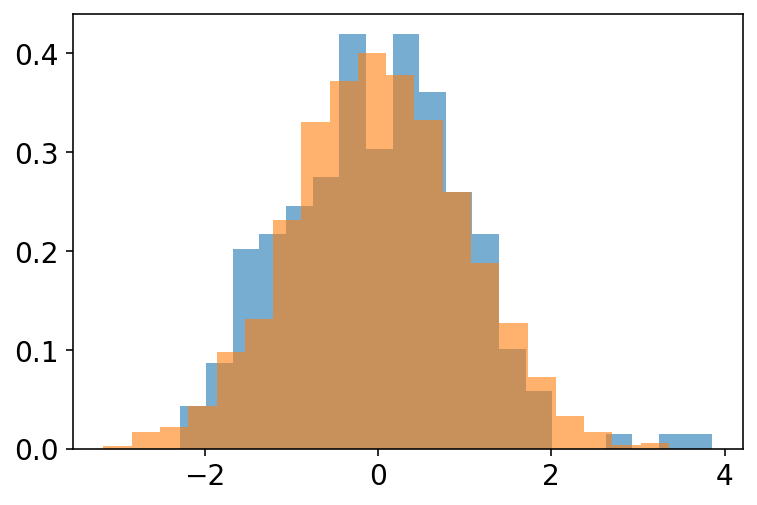

In [269]:
plt.hist(result_with_ethnicity_and_precinct.resid_pearson, bins=20, alpha=0.6, density=True)
plt.hist(np.random.normal(0, 1, size=10 * len(result_with_ethnicity_and_precinct.resid_pearson)), bins=20, alpha=0.6, density=True)
plt.show()

In [129]:
alpha

0.035756631193472194

In [130]:
1/alpha

27.966840460702073

In [27]:
stan_code = """
data {
    int N;
    int D;
    matrix[N, D] X;
    int y[N];
    int u[N];
}

parameters {
    vector[D] beta;
    real<lower=0> phi;
}

transformed parameters {
    vector[N] theta;
    for (n in 1:N) {
        theta[n] = u[n] * exp(X[n] * beta);
    }
}

model {
    for (n in 1:N) {
        y[n] ~ poisson(theta[n]);
    }
}
"""

In [21]:
import pystan

In [29]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a4ebe8bd3e0f9436153b87331da116f NOW.


CompileError: command 'gcc' terminated by signal 6

In [23]:
data = {
    "N": len(X),
    "D": X.drop(columns=["eth_1", "precinct_1", "past.arrests"]).shape[1],
    "X": X.drop(columns=["eth_1", "precinct_1", "past.arrests"]),
    "y": y.astype(int),
    "u": X["past.arrests"].astype(int)
}

In [24]:
fit = model.sampling(data=data, iter=1000)

In [ ]:
pfit = model.sampling(data=data, iter=1000)

In [25]:
result_with_ethnicity_and_precinct.params

eth_2          0.010188
eth_3         -0.419001
precinct_2    -0.149050
precinct_3     0.559955
precinct_4     1.210636
                 ...   
precinct_72    1.464985
precinct_73    0.991018
precinct_74    1.151460
precinct_75    1.571225
intercept     -1.378868
Length: 77, dtype: float64

In [35]:
r

21.88505098420496

In [34]:
1 / np.sqrt(r)

0.21375989066029527

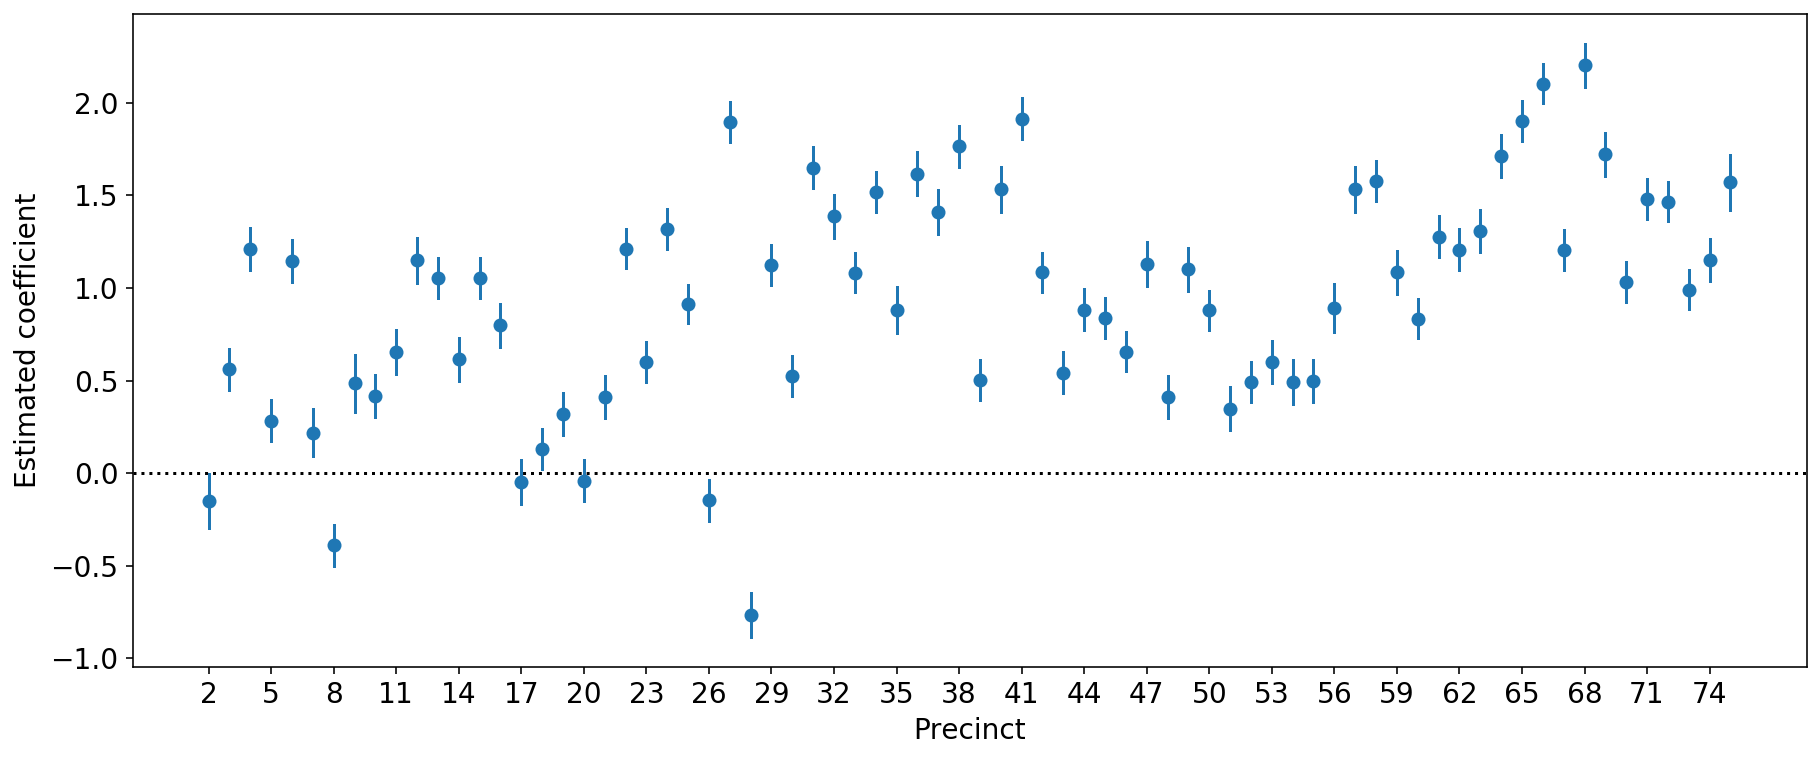

In [104]:
precinct_coefs = result_with_ethnicity_and_precinct.params.iloc[2:-1]
precinct_interval = result_with_ethnicity_and_precinct.conf_int().reindex(precinct_coefs.index)

plt.figure(figsize=(15, 6))
plt.plot(precinct_coefs, 'o')
for precinct, interval in precinct_interval.iterrows():
    plt.plot([precinct, precinct], interval, color='C0')
plt.axhline(y=0, linestyle=':', color='black')
plt.xticks(
    precinct_coefs.index[::3],
    [int(x[1]) for x in precinct_coefs.index.str.split("_",)][::3]
)
plt.ylabel("Estimated coefficient", fontsize=14)
plt.xlabel("Precinct", fontsize=14)
plt.show()

(array([0.00188637, 0.00330114, 0.00848866, 0.03206826, 0.02735234,
        0.01603413, 0.01084662, 0.00377274, 0.00188637, 0.00047159]),
 array([-39.6271479 , -30.20280686, -20.77846582, -11.35412478,
         -1.92978373,   7.49455731,  16.91889835,  26.34323939,
         35.76758043,  45.19192148,  54.61626252]),
 <a list of 10 Patch objects>)

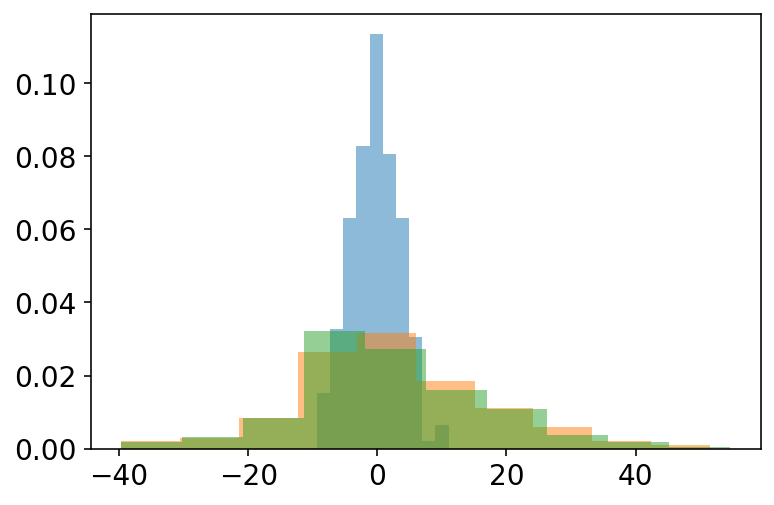

In [87]:
plt.hist(result_with_ethnicity_and_precinct.resid_pearson, density=True, alpha=0.5)
plt.hist(result_with_ethnicity.resid_pearson, density=True, alpha=0.5)
plt.hist(result_no_indicators.resid_pearson, density=True, alpha=0.5)

In [38]:
print(result_with_ethnicity_and_precinct.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      148
Model Family:                 Poisson   Df Model:                           76
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2566.9
Date:                Thu, 21 May 2020   Deviance:                       3427.1
Time:                        05:45:12   Pearson chi2:                 3.24e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
eth_2           0.0102      0.007      1.498      

### Overdispersion

In [17]:
def group_residuals(y_true, y_pred, n_groups=20, offset=0):
    residuals = y_true - y_pred
    quantiles = pd.qcut(y_true, n_groups, labels=False)
    groups = residuals.groupby(quantiles)
    mean = groups.mean()
    std = groups.std()
    return mean.index + offset, mean.values, std.values

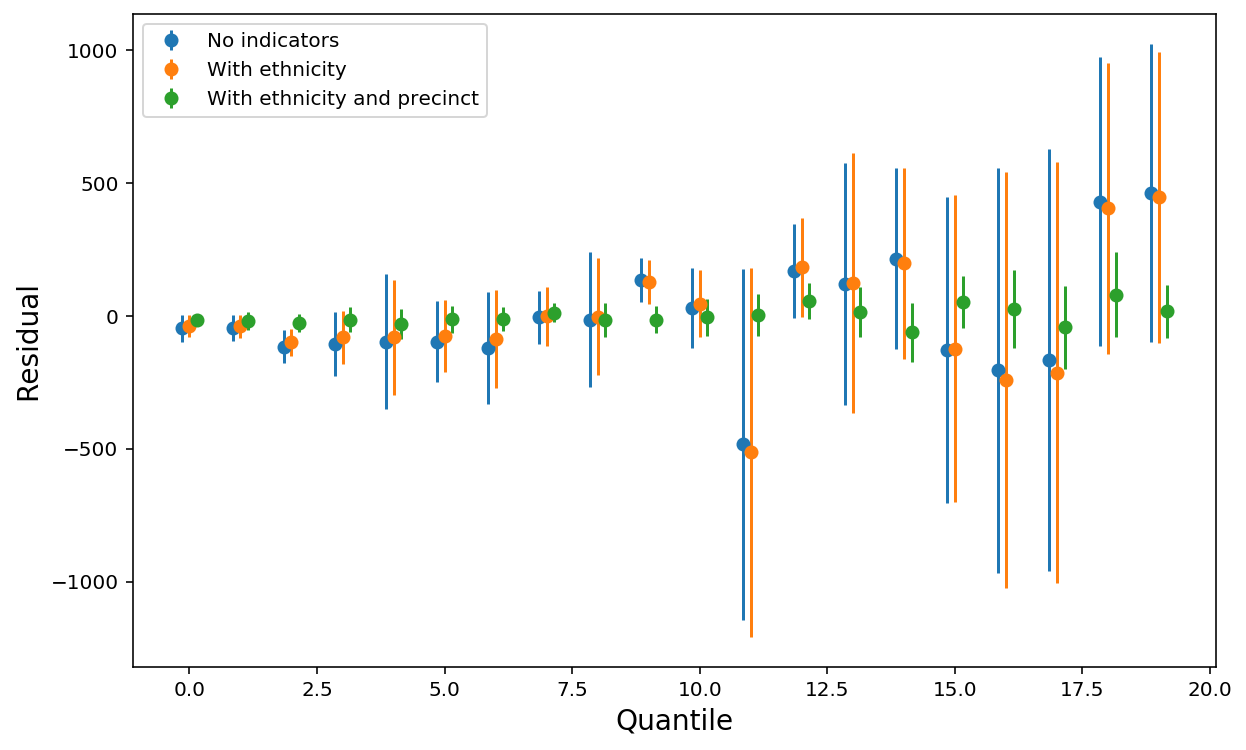

In [18]:
f = plt.figure(figsize=(6 * 1.618, 6))
plt.errorbar(
    *group_residuals(df2.stops, result_no_indicators.fittedvalues, offset=-0.15),
    label='No indicators',
    marker='o',
    linestyle=''
)
plt.errorbar(
    *group_residuals(df2.stops, result_with_ethnicity.fittedvalues),
    label='With ethnicity',
    marker='o',
    linestyle=''
)
plt.errorbar(
    *group_residuals(df2.stops, result_with_ethnicity_and_precinct.fittedvalues, offset=0.15),
    label='With ethnicity and precinct',
    marker='o',
    linestyle=''
)

plt.xlabel("Quantile", fontsize=14)
plt.ylabel("Residual", fontsize=14)
plt.legend(loc='upper left')
plt.show()

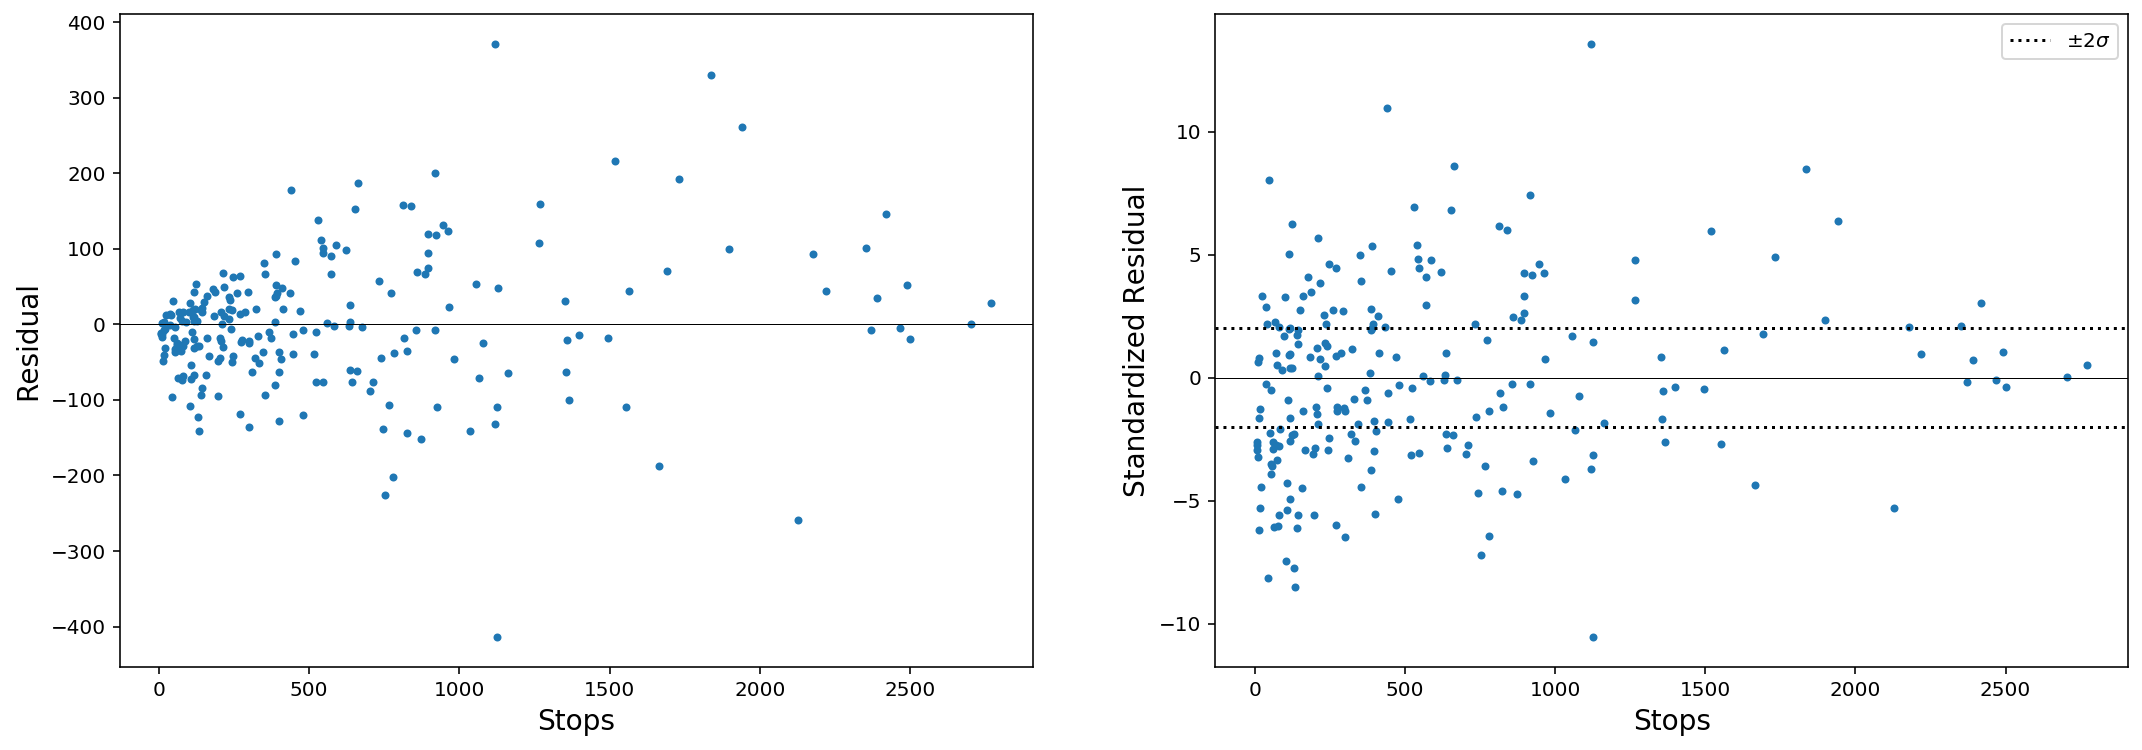

In [19]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(
    df2.stops,
    df2.stops - result_with_ethnicity_and_precinct.fittedvalues,
    marker='.',
    linestyle=''
)
axes[0].axhline(y=0, color='black', linewidth=0.5)
axes[0].set_ylabel("Residual", fontsize=14)
axes[0].set_xlabel("Stops", fontsize=14)

axes[1].plot(
    df2.stops,
    (df2.stops - result_with_ethnicity_and_precinct.fittedvalues) / np.sqrt(result_with_ethnicity_and_precinct.fittedvalues),
    marker='.',
    linestyle=''
)

axes[1].axhline(y=-2, linestyle=':', color='black', label="$\pm 2\sigma$")
axes[1].axhline(y=+2, linestyle=':', color='black',)
axes[1].axhline(y=0, color='black', linewidth=0.5)
axes[1].set_ylabel("Standardized Residual", fontsize=14)
axes[1].set_xlabel("Stops", fontsize=14)
axes[1].legend()


plt.show()

In [45]:
scipy.stats.chi2(df=result_with_ethnicity_and_precinct.df_resid).cdf(3238.9875456623336)

1.0

In [42]:
(result_with_ethnicity_and_precinct.resid_pearson ** 2).sum()

3238.9875456623336

In [43]:
scipy.stats.chisquare(result_with_ethnicity_and_precinct.resid_pearson, ddof=result_with_ethnicity_and_precinct.df_resid, )

Power_divergenceResult(statistic=-9774.362425625852, pvalue=1.0)

The standardised residuals are already stored in the fitted model in the attribute `resid_pearson`, so we don't need to compute these by hand.

In [20]:
z_residuals = (df2.stops - result_with_ethnicity_and_precinct.fittedvalues) / np.sqrt(result_with_ethnicity_and_precinct.fittedvalues)
(z_residuals == result_with_ethnicity_and_precinct.resid_pearson).all()

True

In [21]:
overdispersion_ratio = sum(result_with_ethnicity_and_precinct.resid_pearson ** 2) / result_with_ethnicity_and_precinct.df_resid
overdispersion_test = scipy.stats.chisquare(
    result_with_ethnicity_and_precinct.resid_pearson,
    ddof=result_with_ethnicity_and_precinct.df_resid,
)

In [22]:
print(f"Overdispersion ratio is {overdispersion_ratio:.2f}")
print(f"p-value of overdispersion test is {overdispersion_test.pvalue:.2f}")

Overdispersion ratio is 21.24
p-value of overdispersion test is 1.00
